# 🌊 Setting Up Your XBeach Model in Google Colab

This notebook provides a streamlined workflow for preprocessing your XBeach model within the Google Colab environment. It focuses on two key aspects:

## 🧱 Defining Non-Erodible Areas

- A `non_erodible_layer.dep` file is automatically generated.
- This file uses a GeoJSON polygon to specify non-erodible zones within the model domain.
- Users can define the thickness of the erodible sediment layer.
- This prevents erosion in areas such as rocky outcrops, seawalls, or vegetation mats.

## 🏖️ Spatial Manning Roughness Assignment

- A `manning_layer.dep` file is created, assigning spatially varying Manning's roughness coefficients.
- This leverages a GeoJSON file containing polygons with associated Manning values.
- Accurately representing surface roughness is crucial for realistic flow resistance and wave propagation.

## ⚙️ Integrating with XBeach `params.txt`

- The notebook automatically updates your `params.txt` file with the paths to the generated `*.dep` files.
- This seamless integration ensures that your XBeach model uses the newly defined non-erodible and Manning layers.

---

### 🚀 Before you start:

- Ensure your GeoJSON files are correctly projected (matching the defined EPSG code) and placed in the designated folders.
- Update file paths and parameters as necessary to align with your project requirements.

# 📦 Installing and Importing Required Libraries

In this cell, we:

- Install any missing libraries (`rasterio` in this case).
- Import essential Python packages for:
  - File handling and numerical operations (`os`, `numpy`, `json`)
  - Plotting and visualization (`matplotlib`)
  - Geospatial data processing (`geopandas`, `shapely`)
  - Working with NetCDF datasets (`xarray`)
  - Google Drive integration (`google.colab.drive`)
  - Progress tracking (`tqdm`)

These tools are the foundation for preprocessing XBeach model inputs in Python.

In [2]:
# 📦 Install required package(s) (quietly)
!pip install --quiet rasterio

# 🔗 Mount Google Drive (only needs to be done once per session)
from google.colab import drive
drive.mount('/content/drive/')

# 🌐 Import core libraries
import os                          # File and folder operations
import json                        # For reading/writing JSON files
import numpy as np                 # Numerical operations
import matplotlib.pyplot as plt    # Plotting
import matplotlib.colors as mcolors  # Custom color scaling

# 🗺️ Import geospatial libraries
import xarray as xr                # NetCDF data handling
import geopandas as gpd            # Vector data (e.g., GeoJSON)
from shapely.geometry import Point # For point-in-polygon checks

# ⏳ Optional: progress bar for loops
from tqdm import tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 20.1 MB/s eta 0:00:00
Mounted at /content/drive/


# 📁 Set Up Working Directory and Project Structure

In this cell, we:

- Set the working directory to the folder where your XBeach project is stored on Google Drive.
- Define the subfolder containing the model (e.g., `"Model"`).
- Create an `output` folder inside your model directory if it doesn't already exist — this is where we will save all results and processed files.

> 📌 Make sure to update the path to match your own Drive structure.

In [26]:
# Set the working directory to the main project folder on your Drive
os.chdir('/content/drive/MyDrive/Coastal_hydrodynamics/XBeach')
print("Current working directory set to:", os.getcwd())

# Define the folder containing the XBeach model
XBfolder = "Model"
# Define the folder containing the GeoJson files to interpolate
GeoJsonfolder = os.path.join(XBfolder,"GeoJson_INPUT")

# Create an 'output' folder to store results (if it doesn't exist)
output_folder = os.path.join(XBfolder, "output")
os.makedirs(output_folder, exist_ok=True)
print("Output folder created (if not already present):", output_folder)

Current working directory set to: /content/drive/MyDrive/Coastal_hydrodynamics/XBeach
Output folder created (if not already present): Model/output


# 🧭 Define the Coordinate Reference System (CRS)

This cell defines a helper function `CRS_setup()` that calculates the correct EPSG code based on a UTM zone (e.g., `"27N"` for Cape Verde).

EPSG codes are used for spatial referencing and are essential when working with maps and vector data. After defining the function, we use it to set the EPSG code for the current project.

In [4]:
# Define a function to calculate the EPSG code from a UTM zone
def CRS_setup(utm_zone="27N"):
    """
    Returns the EPSG code for a given UTM zone (e.g., "27N" or "33S").

    Args:
        utm_zone (str): The UTM zone as a string (e.g., "27N").

    Returns:
        int: The corresponding EPSG code.
    """
    zone_number = int(utm_zone[:-1])
    hemisphere = utm_zone[-1].upper()

    if hemisphere == "N":
        epsg_code = 32600 + zone_number
    elif hemisphere == "S":
        epsg_code = 32700 + zone_number
    else:
        raise ValueError("Invalid UTM zone format. Use format like '33N' or '33S'.")

    print(f"Using EPSG:{epsg_code} for UTM Zone {utm_zone}")
    return epsg_code

# Set your project's EPSG code by providing the UTM zone
epsg_code = CRS_setup(utm_zone="17N")  # ← Change this if needed

Using EPSG:32617 for UTM Zone 17N


# 🗺️ Visualize and Export the XBeach Grid and Bathymetry

This cell runs a function `export_input()` that performs the following tasks:

- Loads the XBeach grid (`x.grd`, `y.grd`) and bathymetry (`bed.dep`)
- Plots the grid with a color-coded elevation/depth map
- Saves the figure as a high-resolution **PDF**
- Converts the model grid into a **GeoJSON** file, useful for viewing in GIS software

> 📤 All outputs are saved in the `output/` folder within your model directory.

✅ PDF figure saved to: Model/output/grid_topography.pdf


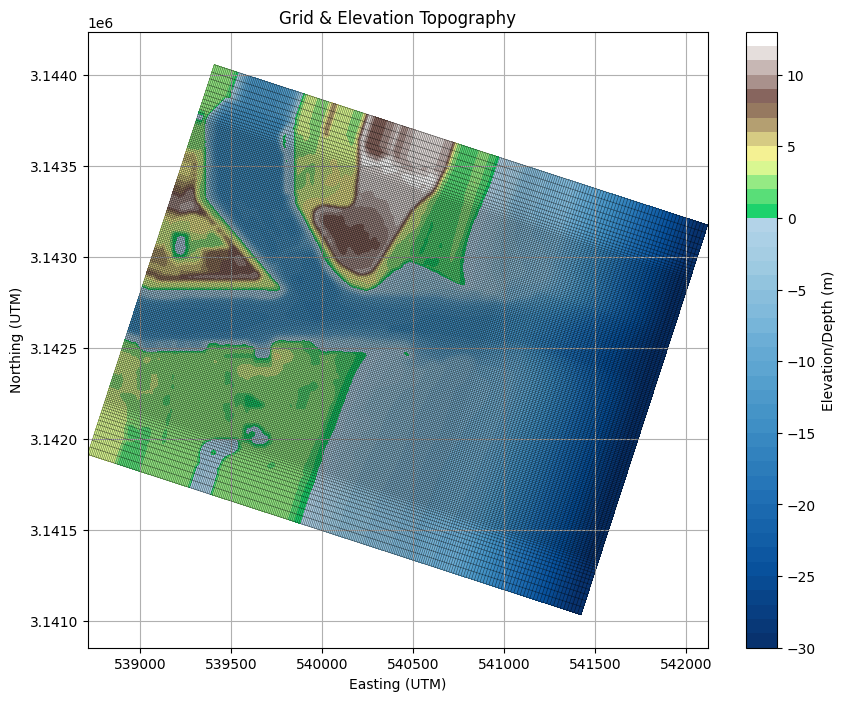

✅ Grid exported to GeoJSON: Model/output/grid.geojson


In [5]:
# Load grid and depth data
x_grid = np.loadtxt(os.path.join(XBfolder, "x.grd"))
y_grid = np.loadtxt(os.path.join(XBfolder, "y.grd"))
depth_grid = np.loadtxt(os.path.join(XBfolder, "bed.dep"))

# Define the min/max elevation values
min_depth = np.min(depth_grid)
max_depth = np.max(depth_grid)
sea_level = 0  # Sea level reference

# Normalize for colormap
norm = mcolors.TwoSlopeNorm(vmin=min_depth, vcenter=sea_level, vmax=max_depth)

# Custom colormap
cmap = mcolors.LinearSegmentedColormap.from_list(
    "custom_blue_terrain",
    plt.cm.Blues_r(np.linspace(0, 0.7, 128)).tolist() +
    plt.cm.terrain(np.linspace(0.25, 1, 128)).tolist(),
    N=256
)

# ✅ PLOT the grid and bathymetry
plt.figure(figsize=(10, 8))
plt.plot(x_grid, y_grid, color='black', alpha=0.5, linewidth=0.5)       # vertical lines
plt.plot(x_grid.T, y_grid.T, color='black', alpha=0.5, linewidth=0.5)   # horizontal lines
contour = plt.contourf(x_grid, y_grid, depth_grid, cmap=cmap, norm=norm, levels=50)
cbar = plt.colorbar(contour)
cbar.set_label("Elevation/Depth (m)")
plt.xlabel("Easting (UTM)")
plt.ylabel("Northing (UTM)")
plt.title("Grid & Elevation Topography")
plt.axis("equal")
plt.grid(True)

# Save figure to PDF
pdf_path = os.path.join(output_folder, "grid_topography.pdf")
plt.savefig(pdf_path, format="pdf")
print(f"✅ PDF figure saved to: {pdf_path}")

plt.show()

# ✅ EXPORT GRID as GEOJSON
features = []

# Horizontal lines
for i in range(x_grid.shape[0]):
    coords = [[x_grid[i, j], y_grid[i, j]] for j in range(x_grid.shape[1])]
    features.append({
        "type": "Feature",
        "geometry": {"type": "LineString", "coordinates": coords},
        "properties": {"row": i}
    })

# Vertical lines
for j in range(x_grid.shape[1]):
    coords = [[x_grid[i, j], y_grid[i, j]] for i in range(x_grid.shape[0])]
    features.append({
        "type": "Feature",
        "geometry": {"type": "LineString", "coordinates": coords},
        "properties": {"column": j}
    })

# Build and save the GeoJSON
grid_geojson = {
    "type": "FeatureCollection",
    "features": features,
    "crs": {
        "type": "name",
        "properties": {
            "name": f"urn:ogc:def:crs:EPSG::{epsg_code}"
        }
    }
}

geojson_path = os.path.join(output_folder, "grid.geojson")
with open(geojson_path, "w") as f:
    json.dump(grid_geojson, f, indent=4)

print(f"✅ Grid exported to GeoJSON: {geojson_path}")

# 🧱 Creating a Non-Erodible Layer for XBeach

This cell generates a `non_erodible_layer.dep` file that defines the **non-erodible zone** in your XBeach model. This is useful for simulating scenarios where only a certain thickness of sediment is allowed to erode, or where parts of the domain (e.g., bedrock, seawalls) should remain stable.

## 📘 What is a non-erodible layer?

In XBeach, the `non_erodible_layer.dep` file specifies how much sediment is available for transport in each cell:
- A value of **`0.0`** means the cell is **non-erodible** (solid base).
- A positive value (e.g., **`100.0`**) means the cell contains erodible sediment up to that thickness (in meters).

This layer can be used to simulate rock outcrops, vegetation mats, or infrastructure embedded in the terrain.

## 🧾 How it works in this script:
- Loads the model grid from `x.grd` and `y.grd`
- Loads a polygon from a GeoJSON file representing the non-erodible area
- Ensures the CRS of the GeoJSON matches the model EPSG code
- For each grid cell:
  - If the cell is **inside** the polygon → value is `0.0`
  - If the cell is **outside** → value is the **user-defined erodible thickness** (e.g., `100.0`)
- Saves the resulting array as a `.dep` file for XBeach
- Plots the result and overlays the input polygon for visual confirmation

> ⚠️ Make sure your `non_erodible.geojson` file is correctly projected and covers the desired area within the grid bounds.

✅ GeoJSON EPSG matches expected EPSG:32617
Enter erodible layer thickness in meters (e.g., 100.0): 100


<ipython-input-6-fc30383568a7>:24: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  non_erodible_geom = gdf.unary_union
Rasterizing: 100%|██████████| 190/190 [00:03<00:00, 52.88it/s]


✅ Non-erodible layer saved to: Model/non_erodible_layer.dep


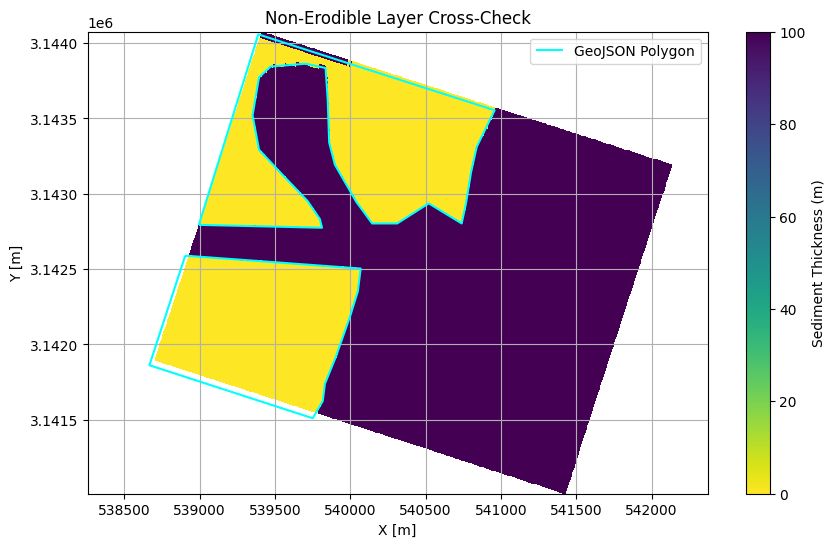

In [6]:
# Load XBeach grid files
x = np.loadtxt(os.path.join(XBfolder, "x.grd"))
y = np.loadtxt(os.path.join(XBfolder, "y.grd"))
nrows, ncols = x.shape

# Load the non-erodible mask (GeoJSON)
geojson_path=os.path.join(GeoJsonfolder,"non_erodible.geojson")

gdf = gpd.read_file(geojson_path)
# Check if GeoJSON CRS matches the EPSG defined earlier

if gdf.crs is None:
    raise ValueError("❌ The GeoJSON has no defined CRS. Please define it before loading.")
elif gdf.crs.to_epsg() != epsg_code:
    raise ValueError(f"❌ EPSG mismatch: GeoJSON EPSG is {gdf.crs.to_epsg()}, but expected EPSG:{epsg_code}")
else:
    print(f"✅ GeoJSON EPSG matches expected EPSG:{epsg_code}")
    gdf = gdf.to_crs(epsg=epsg_code)  # Reproject just in case

# Ask user for sediment thickness (in meters)
sediment_thickness = float(input("Enter erodible layer thickness in meters (e.g., 100.0): "))

# Combine all polygon features into one geometry
non_erodible_geom = gdf.unary_union

# Create raster grid (default = erodible)
raster = np.full((nrows, ncols), sediment_thickness, dtype=np.float32)

# Loop over each grid point and check if it falls inside the non-erodible polygon
for i in tqdm(range(nrows), desc="Rasterizing"):
    for j in range(ncols):
        pt = Point(x[i, j], y[i, j])
        if non_erodible_geom.contains(pt):
            raster[i, j] = 0.0  # Set to non-erodible

# Save raster grid to .dep format
output_path = os.path.join(XBfolder, "non_erodible_layer.dep")
with open(output_path, 'w') as f:
    for row in raster:
        f.write(" ".join(f"{val:.1f}" for val in row) + "\n")

print(f"✅ Non-erodible layer saved to: {output_path}")

# --------------------------------------------------
# 🖼️ Plot the non-erodible layer for visual checking
# --------------------------------------------------
plt.figure(figsize=(10, 6))
pcm = plt.pcolormesh(x, y, raster, shading='auto', cmap='viridis_r')
plt.colorbar(pcm, label="Sediment Thickness (m)")

# Overlay the polygon boundary
gdf.boundary.plot(ax=plt.gca(), color='cyan', linewidth=1.5, label='GeoJSON Polygon')

plt.title("Non-Erodible Layer Cross-Check")
plt.xlabel("X [m]")
plt.ylabel("Y [m]")
plt.axis('equal')
plt.legend()
plt.grid(True)
plt.show()

# 🏖️ Assigning Manning Coefficients to the Model Grid

In this cell, we create a `manning_layer.dep` file for XBeach, assigning Manning roughness coefficients to each grid cell based on a GeoJSON polygon map. This allows the model to represent different surface roughness across the domain, such as dunes, vegetation, urban areas, or bare beach.

## 📘 What is Manning's coefficient?

The **Manning coefficient (`n`)** is a dimensionless value that describes **surface roughness** in hydraulic models. Lower values (e.g., 0.015) represent smooth surfaces like clean sand, while higher values (e.g., 0.050+) represent rough terrain like dense vegetation or urban rubble.

In XBeach, Manning's `n` can influence **flow resistance**, **overwash propagation**, and **flood extent**. Accurately defining spatial variations in `n` can improve the realism of model outputs.

## 🧾 How it works in this script:
- The model grid is filled with a **default value** (e.g., `0.025`).
- A GeoJSON file provides polygons, each with a `"manning"` attribute.
- For each grid cell, if the cell lies within a polygon, the cell takes on the polygon's `manning` value.

> 📎 Reference for real-world Manning values:  
> [Manning's n Tables – Oregon State University](https://www.fsl.orst.edu/geowater/FX3/help/8_Hydraulic_Reference/Mannings_n_Tables.htm)

---

### 🌊 Example Manning Coefficients for Coastal Environments

| Surface Type                        | Manning's n  |
|------------------------------------|--------------|
| Smooth sandy beach (bare)          | 0.015 – 0.025 |
| Dune vegetation (low)              | 0.030 – 0.045 |
| Dune vegetation (dense)            | 0.045 – 0.060 |
| Urban or built-up area             | 0.050 – 0.100 |
| Mangrove, saltmarsh, or coral rubble | 0.060 – 0.150 |

> ✅ Make sure your `manning_roughness.geojson` file contains a **`"manning"` field** with numeric values.

✅ GeoJSON EPSG matches expected EPSG:32617
Enter default Manning coefficient for undefined areas (e.g., 0.025): 0.025


Interpolating Manning values: 100%|██████████| 190/190 [00:20<00:00,  9.46it/s]


✅ Manning coefficient layer saved to: Model/manning_layer.dep


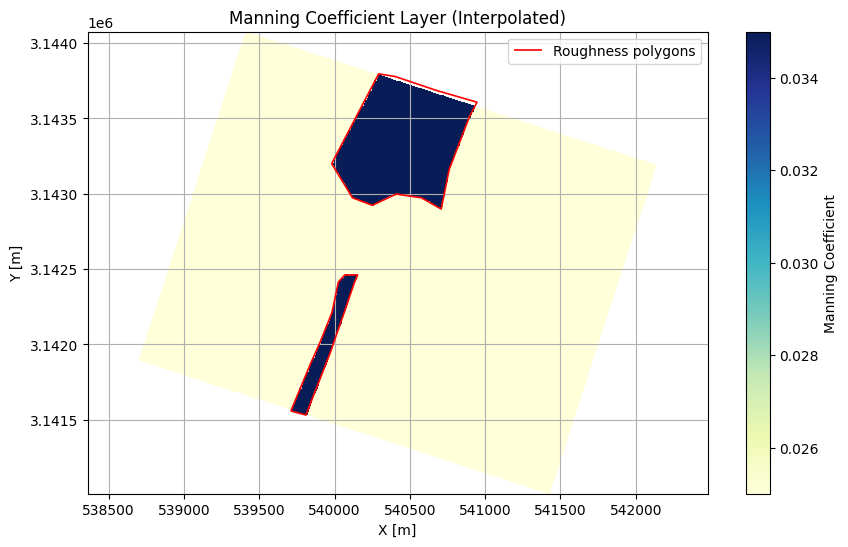

In [7]:
# Load XBeach grid files
x = np.loadtxt(os.path.join(XBfolder, "x.grd"))
y = np.loadtxt(os.path.join(XBfolder, "y.grd"))
nrows, ncols = x.shape

# Load the GeoJSON containing manning values
geojson_path=os.path.join(GeoJsonfolder,"manning_roughness.geojson")
gdf = gpd.read_file(geojson_path)

# Check CRS consistency
if gdf.crs is None:
    raise ValueError("❌ The GeoJSON has no defined CRS. Please define it before loading.")
elif gdf.crs.to_epsg() != epsg_code:
    raise ValueError(f"❌ EPSG mismatch: GeoJSON EPSG is {gdf.crs.to_epsg()}, but expected EPSG:{epsg_code}")
else:
    print(f"✅ GeoJSON EPSG matches expected EPSG:{epsg_code}")
    gdf = gdf.to_crs(epsg=epsg_code)

# Ask user for default Manning value
default_manning = float(input("Enter default Manning coefficient for undefined areas (e.g., 0.025): "))

# Initialize raster grid with default value
manning_grid = np.full((nrows, ncols), default_manning, dtype=np.float32)

# Loop over each cell and assign Manning value from polygon if available
for i in tqdm(range(nrows), desc="Interpolating Manning values"):
    for j in range(ncols):
        pt = Point(x[i, j], y[i, j])
        for _, row in gdf.iterrows():
            if row.geometry.contains(pt):
                manning_grid[i, j] = float(row["Manning"])
                break  # Use the first matching polygon

# Save as .dep file
output_path = os.path.join(XBfolder, "manning_layer.dep")
with open(output_path, 'w') as f:
    for row in manning_grid:
        f.write(" ".join(f"{val:.4f}" for val in row) + "\n")

print(f"✅ Manning coefficient layer saved to: {output_path}")

# --------------------------------------------------
# 🖼️ Plot the Manning layer for visual checking
# --------------------------------------------------
plt.figure(figsize=(10, 6))
pcm = plt.pcolormesh(x, y, manning_grid, shading='auto', cmap='YlGnBu')
plt.colorbar(pcm, label="Manning Coefficient")

# Overlay the polygon boundaries
gdf.boundary.plot(ax=plt.gca(), color='red', linewidth=1.2, label='Roughness polygons')

plt.title("Manning Coefficient Layer (Interpolated)")
plt.xlabel("X [m]")
plt.ylabel("Y [m]")
plt.axis('equal')
plt.legend()
plt.grid(True)
plt.show()

# 📝 Updating `params.txt` with Additional Layer Files

This cell programmatically updates your `params.txt` file to include:

- `bedfricfile = manning_layer.dep` → links to the spatial map of Manning roughness coefficients
- `ne_layer    = non_erodible_layer.dep` → links to the map of non-erodible zones

These files are generated from previous steps in this notebook and are required for XBeach to use spatially varying parameters.

## 🔧 What the code does:
- Loads your existing `params.txt` file
- **Searches for** the `bedfricfile` and `ne_layer` entries
- If found:
  - Updates them to ensure they reference the correct file names
- If not found:
  - **Inserts them** right before the section titled:
    ```
    %%% Output variables %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    ```
- Only prints confirmation if actual changes were made

This ensures the input file remains clean, accurate, and reproducible.

In [28]:
# Define the path to params.txt
params_path = os.path.join(XBfolder, "params.txt")

# Load all lines
with open(params_path, 'r') as f:
    lines = f.readlines()

# Flags to track updates
modified = False
bedfricfile_line = "bedfricfile = manning_layer.dep\n"
ne_layer_line    = "ne_layer    = non_erodible_layer.dep\n"

# Track if keys were found and updated
bedfricfile_found = False
ne_layer_found = False

for i, line in enumerate(lines):
    if line.strip().startswith("bedfricfile"):
        if line != bedfricfile_line:
            lines[i] = bedfricfile_line
            modified = True
        bedfricfile_found = True
    if line.strip().startswith("ne_layer"):
        if line != ne_layer_line:
            lines[i] = ne_layer_line
            modified = True
        ne_layer_found = True

# Find insert location (before output variables section)
insert_idx = None
for i, line in enumerate(lines):
    if "%%% Output variables" in line:
        insert_idx = i
        break

# Insert missing lines if needed
to_insert = []
if not bedfricfile_found:
    to_insert.append(bedfricfile_line)
    modified = True
if not ne_layer_found:
    to_insert.append(ne_layer_line)
    modified = True

if to_insert and insert_idx is not None:
    lines = lines[:insert_idx] + to_insert + ["\n"] + lines[insert_idx:]

# Save changes (if any)
if modified:
    with open(params_path, 'w') as f:
        f.writelines(lines)
    print("✅ params.txt updated: bedfricfile and/or ne_layer set correctly.")
else:
    print("ℹ️ No changes needed: bedfricfile and ne_layer already correctly defined.")

ℹ️ No changes needed: bedfricfile and ne_layer already correctly defined.


# 🌊 Configure Wave Model and Directional Resolution (`wavemodel`, `dtheta`/`dtheta_s`)

This cell allows you to choose the hydrodynamic mode for your XBeach simulation and automatically configures the correct directional resolution keyword in `params.txt`.

## ✅ What the code does:

1. **Asks you to select the wave model mode (`wavemodel`)**:
   - `0` = Stationary (wave-averaged)
   - `1` = Surfbeat (resolves wave groups and infragravity waves)
   - `2` = Non-hydrostatic (fully wave-resolving)

2. **Updates or inserts the correct `wavemodel = X` line** in the file.

3. **Ensures the correct directional resolution keyword is present:**
   - If `wavemodel = 0` → uses `dtheta = 10`
   - If `wavemodel = 1 or 2` → uses `dtheta_s = 10`

4. **Removes the incorrect keyword if it was already present**, to avoid confusion or model errors.

5. Inserts these settings just before the output section:
    ```
    %%% Output variables %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    ```
This ensures that your simulation mode and spectrum configuration are consistent and correctly formatted — an essential step before running the model.

In [9]:
# Ask the user to select the wave model type
print("Select the wave model type:")
print("  0 = Stationary (wave-averaged, no infragravity waves)")
print("  1 = Surfbeat (wave group scale, resolves long waves)")
print("  2 = Non-hydrostatic (fully wave-resolving)")

user_wavemodel = input("Enter wavemodel (0, 1, or 2): ").strip()
if user_wavemodel not in ["0", "1", "2"]:
    raise ValueError("Invalid input. Please enter 0, 1, or 2.")

# Load the params.txt lines again, just to be safe
params_path = os.path.join(XBfolder, "params.txt")
with open(params_path, 'r') as f:
    lines = f.readlines()

# Find the line where the output section starts
insert_idx = None
for i, line in enumerate(lines):
    if "%%% Output variables" in line:
        insert_idx = i
        break
if insert_idx is None:
    raise ValueError("❌ Could not find output variable section in params.txt.")

# --------- WAVEMODEL ---------
wavemodel_line = f"wavemodel    = {user_wavemodel}\n"
wavemodel_found = False

for i, line in enumerate(lines):
    if line.strip().startswith("wavemodel"):
        lines[i] = wavemodel_line
        wavemodel_found = True
        print("🔄 Updated existing wavemodel line.")
        break

if not wavemodel_found:
    lines = lines[:insert_idx] + [wavemodel_line] + lines[insert_idx:]
    print("➕ Inserted wavemodel line.")

# --------- DTHETA vs DTHETA_S ---------
correct_key = "dtheta" if user_wavemodel == "0" else "dtheta_s"
wrong_key   = "dtheta_s" if correct_key == "dtheta" else "dtheta"
correct_line = f"{correct_key}     = 10\n"

correct_found = False
wrong_found = False

for i, line in enumerate(lines):
    if line.strip().startswith(correct_key):
        lines[i] = correct_line
        correct_found = True
    elif line.strip().startswith(wrong_key):
        lines[i] = ""  # remove incorrect key
        wrong_found = True

if not correct_found:
    lines = lines[:insert_idx] + [correct_line] + lines[insert_idx:]
    print(f"➕ Inserted missing {correct_key} = 10")

if wrong_found:
    print(f"❌ Removed incorrect key: {wrong_key}")

# --------- SAVE ---------
with open(params_path, 'w') as f:
    f.writelines(lines)

print(f"✅ Saved params.txt with wavemodel = {user_wavemodel} and {correct_key} = 10")

Select the wave model type:
  0 = Stationary (wave-averaged, no infragravity waves)
  1 = Surfbeat (wave group scale, resolves long waves)
  2 = Non-hydrostatic (fully wave-resolving)
Enter wavemodel (0, 1, or 2): 0
🔄 Updated existing wavemodel line.
✅ Saved params.txt with wavemodel = 0 and dtheta = 10


# 🏖️ Add Mean Grain Size (D50) to `params.txt`

This step adds a new line to define the **mean sediment grain diameter** for the model.

## 💡 What is `D50`?
`D50` is the median grain size (in meters) of the sediment used in the simulation.  
Typical values include:
- **0.0002** m → fine sand (~200 µm)
- **0.0005** m → medium sand
- **0.0010** m → coarse sand or fine gravel

## 🔧 What the code does:
- Prompts the user to enter a `D50` value
- Inserts or updates the `D50` line in `params.txt`
- Ensures it appears before the `%%% Output variables` section

This parameter is important for setting the sediment transport properties of the model.

In [10]:
# Ask user for D50 value
user_d50 = float(input("Enter D50 value (in meters, e.g., 0.0002 for 200 µm sand): "))
d50_line = f"D50 = {user_d50:.6f}\n"

# Check if D50 already exists and update it
d50_found = False
for i, line in enumerate(lines):
    if line.strip().startswith("D50"):
        if line != d50_line:
            lines[i] = d50_line
            modified = True
        d50_found = True
        break

# Insert if missing
if not d50_found and insert_idx is not None:
    lines = lines[:insert_idx] + [d50_line] + lines[insert_idx:]
    modified = True

# Save the final updated params.txt
params_path = os.path.join(XBfolder, "params.txt")

with open(params_path, 'w') as f:
    f.writelines(lines)

print("✅ All changes to params.txt have been saved.")

Enter D50 value (in meters, e.g., 0.0002 for 200 µm sand): 0.0002
✅ All changes to params.txt have been saved.


# 🌊 Create `jonswap.txt` from Wave Time Series

This cell converts a time series of offshore wave conditions into the `jonswap.txt` format used by XBeach for instationary wave forcing.

---

## 📁 File Paths and Folder Setup

Before running the cell:

- Make sure your working folder (e.g., `XBfolder`) points to the correct directory in your Google Drive.
- Place your wave time series in a file called **`Waves.csv`** inside that folder.
- Also include an existing **`jonswap.txt`** file — this is used as a template to extract the constants:  
  - `gammajsp` (peak enhancement factor)
  - `s` (directional spreading coefficient)
  - `dtbc` (time step of offshore boundary condition)

---

## 📘 Required format of `Waves.csv`

Your `Waves.csv` file **must include these columns** with exactly these headers:

| Column   | Description                             |
|----------|-----------------------------------------|
| `time`   | Timestamps (ISO format or parseable datetime) |
| `VHM0`   | Significant wave height \( H_{m0} \) [m] |
| `VTPK`   | Peak wave period \( T_p \) [s]          |
| `VMDR`   | Mean wave direction [°], nautical convention |

> 📝 You can obtain these variables from sources like ERA5, CMEMS, or in-situ instruments.

---

## 🧾 What the code does:
- Loads the wave time series from `Waves.csv`
- Calculates the duration between records
- Repeats `gammajsp`, `s`, and `dtbc` for all rows
- Saves the result in a new `jonswap.txt` file (same folder)
- Plots the wave height, period, and direction
- Prints the total simulation duration (sum of all durations)

This step prepares time-varying boundary conditions for realistic, process-based modeling in XBeach.


<ipython-input-16-73d913ecc7ff>:20: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
  durations.iloc[0] = durations.iloc[1]  # Fill first duration with second one


✅ jonswap.txt saved at: Model/jonswap.txt
🕓 Total simulation duration: 183600.0 seconds


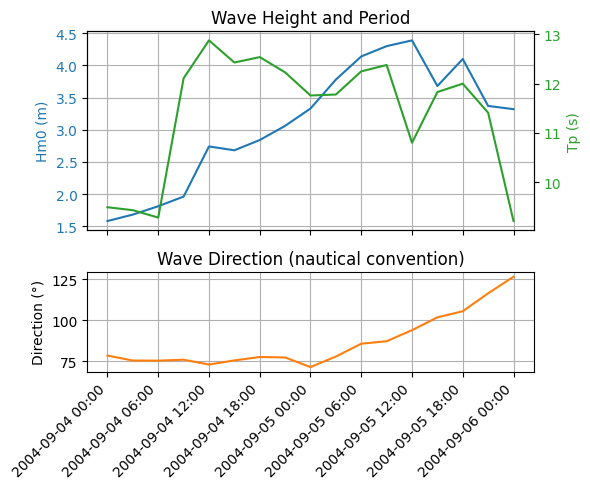

In [16]:
# 📦 Required imports
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

# 📁 Define paths
waves_csv_path = os.path.join(XBfolder, "Wave_input/Waves.csv")
jonswap_input_path = os.path.join(XBfolder, "jonswap.txt")
jonswap_output_path = os.path.join(XBfolder, "jonswap.txt")  # overwrite or redirect as needed

# 📄 Load wave time series from CSV
wave_df = pd.read_csv(waves_csv_path)

# Convert time to datetime
wave_df["time"] = pd.to_datetime(wave_df["time"])

# Calculate durations between each row (in seconds)
durations = wave_df["time"].diff().dt.total_seconds()
durations.iloc[0] = durations.iloc[1]  # Fill first duration with second one

# 🔁 Load existing jonswap.txt to grab constants
original_jonswap = np.loadtxt(jonswap_input_path)
gammajsp = original_jonswap[0, 3]
s = original_jonswap[0, 4]
dtbc = original_jonswap[0, 6]

# ✅ Construct new jonswap DataFrame
jonswap_new = pd.DataFrame({
    "Hm0": wave_df["VHM0"],
    "Tp": wave_df["VTPK"],
    "mainang": wave_df["VMDR"],
    "gammajsp": gammajsp,
    "s": s,
    "duration": durations,
    "dtbc": dtbc
})

# 💾 Save the new jonswap.txt
jonswap_new.to_csv(jonswap_output_path, sep=" ", header=False, index=False, float_format="%.4f")
print(f"✅ jonswap.txt saved at: {jonswap_output_path}")

# 🕓 Print total simulation time
total_duration = durations.sum()
print(f"🕓 Total simulation duration: {total_duration:.1f} seconds")

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 📊 Set up figure and axes: 2 subplots (shared x-axis)
fig, axs = plt.subplots(2, 1, figsize=(6, 5), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

# --- Top panel: Hm0 and Tp with twin y-axes ---
ax1 = axs[0]
color_hm0 = 'tab:blue'
color_tp = 'tab:green'

# Plot Hm0 (left y-axis)
ax1.set_ylabel("Hm0 (m)", color=color_hm0)
ax1.plot(wave_df["time"], wave_df["VHM0"], label="Hm0", color=color_hm0)
ax1.tick_params(axis='y', labelcolor=color_hm0)
ax1.grid(True)

# Plot Tp (right y-axis)
ax2 = ax1.twinx()
ax2.set_ylabel("Tp (s)", color=color_tp)
ax2.plot(wave_df["time"], wave_df["VTPK"], label="Tp", color=color_tp)
ax2.tick_params(axis='y', labelcolor=color_tp)

ax1.set_title("Wave Height and Period")

# --- Bottom panel: Wave direction ---
axs[1].plot(wave_df["time"], wave_df["VMDR"], label="Direction (°)", color='tab:orange')
axs[1].set_ylabel("Direction (°)")
axs[1].set_title("Wave Direction (nautical convention)")
axs[1].grid(True)

# Format x-axis and rotate tick labels
axs[1].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d %H:%M"))
for label in axs[1].get_xticklabels():
    label.set_rotation(45)
    label.set_horizontalalignment('right')

# 🖼️ Layout and display
plt.tight_layout()
plt.show()

# ⏱️ Configure Simulation Time and Output Intervals

This cell updates the key time-related parameters in `params.txt` to match the length and resolution of your wave time series.

## 🧾 Parameters set:

| Parameter | Description                                                                 |
|-----------|-----------------------------------------------------------------------------|
| `tstart`  | Start time of the simulation (set to `0`)                                   |
| `tstop`   | End time of the simulation (set to total wave duration, in seconds)         |
| `tintg`   | Interval between **global outputs** (user-defined, in seconds)              |
| `tintm`   | Interval between **mean/variance/max/min outputs** (set to total duration)  |

## 📘 Notes:
- `tstart = 0` means the simulation starts at time zero.
- `tstop` is automatically computed from your wave data (sum of all durations in `jonswap.txt`).
- `tintg` defines how often the model saves global snapshots (e.g., every 300s).
- `tintm` is set to match the total simulation length — so mean results are written once, at the end.

> ⚠️ These parameters must be consistent with your wave forcing and model duration for accurate output.

In [31]:
# Ask user for global output interval
tintg_input = input("Enter global output interval (tintg) in seconds (e.g., 300): ").strip()
if not tintg_input.isdigit():
    raise ValueError("Please enter a numeric value for tintg.")
tintg_input = int(tintg_input)

# Define duration-based values
tstart = 0
tstop = int(total_duration)+1
tintm = tstop  # one mean output at the end

# Adjust tintg so it's a divisor of tstop
for adjusted_tintg in range(tintg_input, 0, -1):
    if total_duration % adjusted_tintg == 0:
        break

if adjusted_tintg != tintg_input:
    print(f"⚠️ Note: {tintg_input}s does not divide total duration ({total_duration}s).")
    print(f"✅ Using adjusted tintg = {adjusted_tintg}s for compatibility.")

# Format lines
time_lines = {
    "tintg": f"tintg        = {adjusted_tintg}\n",
    "tintm": f"tintm        = {int(total_duration)}\n",
    "tstart": f"tstart       = {tstart}\n",
    "tstop": f"tstop        = {tstop}\n\n"
}

# Reload the current params.txt
with open(params_path, 'r') as f:
    lines = f.readlines()

# Remove old definitions
lines = [line for line in lines if not any(line.strip().startswith(k) for k in time_lines)]

# Find insertion point
insert_idx = None
for i, line in enumerate(lines):
    if "%%% Output variables" in line:
        insert_idx = i
        break
if insert_idx is None:
    raise ValueError("Could not find output variable section in params.txt.")

# Insert updated lines
lines = lines[:insert_idx] + list(time_lines.values()) + lines[insert_idx:]

# Save the updated file
with open(params_path, 'w') as f:
    f.writelines(lines)

# Confirm
print("✅ params.txt updated with safe time settings:")
for k, v in time_lines.items():
    print("  ", v.strip())

Enter global output interval (tintg) in seconds (e.g., 300): 7800
⚠️ Note: 7800s does not divide total duration (183600.0s).
✅ Using adjusted tintg = 7650s for compatibility.
✅ params.txt updated with safe time settings:
   tintg        = 7650
   tintm        = 183600
   tstart       = 0
   tstop        = 183601


# 🌍 Adjust Water Level for Sea-Level Rise (`tide.txt`)

This cell updates the `tide.txt` file to include a uniform sea-level rise offset over the duration of the simulation.

## 📄 File format:
`tide.txt` has 2 rows (start and end time) and 3 columns:
```
0       1.00    1.00
2001    1.00    1.00
```

## 📘 What the code does:
- Loads the existing `tide.txt` and reads the current constant water level
- Asks the user to specify a **sea-level rise offset** (in meters)
- Adds that value to the original level
- Rewrites the file with the new constant level applied over the full model duration

> 🌡️ Sea-level rise values can be obtained from NASA's IPCC AR6 Projection Tool:  
👉 [https://sealevel.nasa.gov/ipcc-ar6-sea-level-projection-tool](https://sealevel.nasa.gov/ipcc-ar6-sea-level-projection-tool)

In [20]:
import numpy as np

# 📄 Define file path
tide_path = os.path.join(XBfolder, "tide.txt")

# 🕓 Get model duration (+1 second)
tstart = 0
tstop = int(total_duration) + 1

# 📥 Read the current tide.txt
tide_data = np.loadtxt(tide_path)

# 📊 Extract and show current water level
initial_level = tide_data[0, 1]  # assuming all rows are constant
print(f"🌊 Current tidal elevation used in model: {initial_level:.2f} m")

# Ask the user for sea-level rise value (in meters)
slr = input("Enter sea-level rise offset in meters (e.g., 0.5): ").strip()
try:
    slr = float(slr)
except:
    raise ValueError("Please enter a valid number.")

# Build new tide.txt array: constant water level + slr
new_level = initial_level + slr
tide_updated = np.array([
    [tstart, new_level, new_level],
    [tstop,  new_level, new_level]
])

# 💾 Save the new tide.txt
np.savetxt(tide_path, tide_updated, fmt="%.7e")

print(f"✅ tide.txt updated with constant water level of {new_level:.2f} m from {tstart}s to {tstop}s")

🌊 Current tidal elevation used in model: 1.00 m
Enter sea-level rise offset in meters (e.g., 0.5): 0.8
✅ tide.txt updated with constant water level of 1.80 m from 0s to 183601s


# 📤 Configure Output Variables in `params.txt`

This cell sets the list of output variables that XBeach will save during the simulation by updating the `nglobalvar` and `nmeanvar` blocks in the `params.txt` file.

## 🌍 `nglobalvar` — Global Output Variables

These variables are saved at each **global time step** across the entire grid. They provide a snapshot of key model states during the simulation.

| Variable | Description                           |
|----------|---------------------------------------|
| `zb`     | Bed level (bottom elevation)          |
| `zs`     | Water surface elevation               |
| `H`      | Wave height                           |
| `u`, `v` | Flow velocity components (x, y)       |
| `sedero` | Net sediment erosion/deposition       |
| `c`      | Wave celerity                         |

> ✅ `nglobalvar = 7` ensures all seven variables listed above are saved.

---

## 📊 `nmeanvar` — Mean Output Variables

These are **statistical outputs** saved over short averaging intervals. XBeach computes mean, max, min, and variance (depending on settings) for each of the variables listed.

| Variable  | Description                           |
|-----------|---------------------------------------|
| `zb`      | Bed level                             |
| `zs`      | Water surface elevation               |
| `maxzs`   | Maximum water surface elevation       |
| `H`       | Wave height                           |
| `u`, `v`  | Flow velocity components (x, y)       |
| `sedero`  | Net sediment erosion/deposition       |
| `qx`      | Sediment transport in x-direction     |
| `hh`      | Total water depth                     |

> ✅ `nmeanvar = 9` ensures these nine variables are computed and saved over averaging windows.

---

## 🧠 Notes:
- These blocks **replace** any existing output variable configuration in the file.
- The numbers after `nglobalvar` and `nmeanvar` **must match** the number of lines that follow.
- For more variables and definitions, refer to the official [XBeach Output Variables Documentation](https://xbeach.readthedocs.io/en/latest/output_variables.html).

This setup ensures that your simulation outputs are complete, targeted, and reproducible.

In [21]:
# Define your desired output variables
global_vars = ["zb", "zs", "H", "u", "v", "sedero", "c"]
mean_vars   = ["zb", "zs", "maxzs", "H", "u", "v", "sedero", "qx", "hh"]

# Format them as strings
global_block = [f"nglobalvar   = {len(global_vars)}\n"] + [f"{var}\n" for var in global_vars] + ["\n"]
mean_block   = [f"nmeanvar     = {len(mean_vars)}\n"] + [f"{var}\n" for var in mean_vars]

# Locate where to replace existing output variable blocks
output_start = None
for i, line in enumerate(lines):
    if "%%% Output variables" in line:
        output_start = i
        break

if output_start is not None:
    # Replace everything after the header with new content
    lines = lines[:output_start+1] + global_block + mean_block
    modified = True
else:
    raise ValueError("⚠️ Could not find the output variable section header in params.txt.")

# Save the final updated params.txt
params_path = os.path.join(XBfolder, "params.txt")

with open(params_path, 'w') as f:
    f.writelines(lines)

print("✅ All changes to params.txt have been saved.")

✅ All changes to params.txt have been saved.


In [32]:
# Read and print contents
with open(params_path, 'r') as f:
    params_content = f.read()

print("📄 Final contents of params.txt:\n")
print(params_content)

📄 Final contents of params.txt:

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%% XBeach parameter settings input file                                     %%%
%%%                                                                          %%%
%%% date:     21-Apr-2025 18:51:34                                           %%%
%%% function: xb_write_params                                                %%%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

%%% General %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

alfa         = 0
back         = abs_2d
bcfile       = jonswap.txt
bedfriction  = manning
depfile      = bed.dep
front        = abs_2d
gridform     = xbeach
instat       = jons_table
morfac       = 1
nx           = 248
ny           = 189
outputformat = netcdf
posdwn       = 0
thetamax     = 198
thetamin     = 18
thetanaut    = 1
tideloc      = 2
vardx        = 1
xfile        = x.grd
xori         

---

## 📝 Acknowledgments

This script was developed by **Alessio Rovere** at **Ca' Foscari University of Venice**, with the support of **ChatGPT by OpenAI** for code structuring, optimization, and documentation refinement.

This work is part of the **WARMCOASTS** project, funded by the **European Research Council (ERC)** under the European Union’s Horizon 2020 research and innovation programme (grant agreement n. **802414**).

⚠️ **Disclaimer:**  
The code is provided *as is*, without any warranties or guarantees of correctness. Users are responsible for verifying results and adapting the scripts to their specific needs. Neither the authors nor the European Union can be held responsible for any use that may be made of the information or code contained herein.